In [46]:
# Install dependancies
# Don't run this if you installed via requirements.txt
# %pip install gymnasium numpy tensorflow matplotlib pygame shapely pydot graphviz
# %pip install -r requirements.txt

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
import inspect
import random
import time
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from SquareEnv2 import space2MultiPolygon, SquareEnv
import subprocess
from rich import print as rprint
from IPython.display import HTML, display
import base64
from PIL import Image


2024-06-13 23:22:25.692281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 23:22:25.692320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 23:22:25.692355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 23:22:25.698583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 23:22:26.317958: W tensorflow/compiler/

In [54]:
# Configuration & Enviorment

# I don't need it to be determinisitic
# seed = 42

# Set up the enviorment
# After several hours messing with useless nested folders and __init__.py files, I gave up and
# just did it the way that makes sense instead of the way that appeals to the standard
# So instead of having useless nested directories, I just import directly from the file. I'm not
# intending to publish the enviorment by itself.

#! REMEMBER: Don't forget to increment the run name
env = SquareEnv(
    N=11,
    search_space=8,
    render_mode="pygame",
    shift_rate=.05,
    rot_rate=.03,
    max_steps=1000,
    bound_method='mixed',
    disallow_overlap=True,
    # flatten=True,
    boundary=0,
    max_overlap=1,
    start_valid=True,
    print=True,
    screen_size=(300, 500),
)

num_states = np.product(env.observation_space.shape)
print(f"Size of State Space -> {num_states}")
num_actions = np.product(env.action_space.shape)
print(f"Size of Action Space -> {num_actions}")

upper_bound = env.action_space.high
lower_bound = env.action_space.low

print(f"Max Value of an Action ->")
display(upper_bound)
print(f"Min Value of an Action ->")
display(lower_bound)


Size of State Space -> 33
Size of Action Space -> 33
Max Value of an Action ->


array([0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05,
       0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05,
       0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03, 0.05, 0.05, 0.03])

Min Value of an Action ->


array([-0.05, -0.05, -0.03, -0.05, -0.05, -0.03, -0.05, -0.05, -0.03,
       -0.05, -0.05, -0.03, -0.05, -0.05, -0.03, -0.05, -0.05, -0.03,
       -0.05, -0.05, -0.03, -0.05, -0.05, -0.03, -0.05, -0.05, -0.03,
       -0.05, -0.05, -0.03, -0.05, -0.05, -0.03])

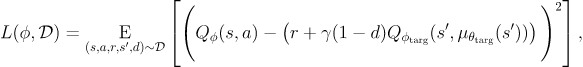

In [55]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, state, action, reward, next_state):
        # Set index to zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = state
        self.action_buffer[index] = action
        self.reward_buffer[index] = reward
        self.next_state_buffer[index] = next_state

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
        # print('update called')
        # Training and updating Actor & Critic networks.
        with tf.GradientTape() as tape:
            # What we think we should do
            target_actions = target_actor(next_state_batch, training=True)
            # How good we think that is (the target Q-Network)
            target_evaluation = target_critic([next_state_batch, target_actions], training=True)
            y = reward_batch + gamma * target_evaluation
            critic_value = critic_model([state_batch, action_batch], training=True)
            # Get the average amount we were off by in predicting how well we would do, squared, and that's the loss
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        # print('critic gradients:')
        # print(critic_grad)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

        return actor_loss, critic_loss

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        return self.update(state_batch, action_batch, reward_batch, next_state_batch)

# This updates target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [56]:
# Define Actor & Critic Models
# Tells a later cell to reset the weights (since we might have changed how we initialize them in this cell)
INIT_WEIGHTS = False

def get_actor():
    # Initialize weights
    # last_init = tf.random_uniform_initializer(minval=-env.shift_rate, maxval=env.shift_rate)
    # last_init = tf.random_uniform_initializer(minval=-3e-3, maxval=3e-3)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(750, activation="tanh")(inputs)
    out = layers.Dense(1024, activation="tanh")(out)
    out = layers.Dense(512, activation="exponential")(out)
    out = layers.Dense(64, activation="tanh")(out)
    out = layers.Dense(256, activation="tanh")(out)
    # outputs = layers.Dense(num_actions, activation='softsign', kernel_initializer=last_init)(out)
    outputs = layers.Dense(num_actions, activation='tanh')(out)

    # This is rescale the output from between -1 - 1 to the appropriate action space scale
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    # model.summary()
    return model

def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="tanh")(state_input)
    state_out = layers.Dense(32, activation="tanh")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="tanh")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(1024, activation="tanh")(concat)
    out = layers.Dense(512, activation="tanh")(concat)
    out = layers.Dense(64, activation="tanh")(concat)
    out = layers.Dense(256, activation="tanh")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    # model.summary()
    return model


In [57]:
# Config
actor_weights_file = 'actor_weights'
critic_weights_file = 'critic_weights'

target_actor_weights_file = 'target_actor_weights'
target_critic_weights_file = 'target_critic_weights'

load_weights = False
loat_target_weights = False

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

if load_weights:
    actor_model.load_weights(actor_weights_file)
    critic_model.load_weights(critic_weights_file)

if loat_target_weights:
    target_actor.load_weights(target_actor_weights_file)
    target_critic.load_weights(target_critic_weights_file)
else:
    # Making the weights equal initially
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.0015

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# How many resets we're running for.
total_episodes = 500
# Discount factor for future rewards
patience = gamma = 0.99
# Used to update target networks
tau = 0.005

avg_reward_episodes = 40

# This used to be a custom OUActionNoise class, but it a paper came out saying that
# gaussian noise works just as well
# noise = lambda std=std_dev: np.random.normal(scale=std, size=env.action_space.shape)
std_dev=0.2
noise = lambda mu=0, std_dev=std_dev: random.gauss(mu, std_dev)
add_noise = True
noise_cooldown = actor_lr * 4

buffer = Buffer(10000, batch_size=64)

reset_weights = False
reset_weights_once = True


In [58]:
# Load Weights
if not INIT_WEIGHTS:
    actor_model.save_weights('actor_model_init.h5')
    critic_model.save_weights('critic_model_init.h5')
    target_actor.save_weights('target_actor_init.h5')
    target_critic.save_weights('target_critic_init.h5')
    INIT_WEIGHTS = True

In [59]:
# Show our configuration in the window
env.show_strings = [
    'ML Config:',
    f'gamma: {gamma}',
    f'tau: {tau}',
    f'Buffer Capacity: {buffer.buffer_capacity}',
    f'Buffer Batch Size: {buffer.batch_size}',
    # f'avg of prev: {avg_reward_episodes}',
    '-------------------------',
    'Env Config:',
    f'Number of Squares: {env.N}',
    f'Max Steps: {env.max_steps}',
    f'Max Overlap: {env.max_overlap}',
    f'Shift Rate: {env.shift_rate}',
    f'Rotation Rate: {env.rot_rate}',
    f'Start Valid: {env.start_valid}',
    f'Boundary: {env.boundary}',
    f'Bound Method: {env.bound_method}',
    '-------------------------',
]

In [60]:
# A function to save all the information from the runs
def save_output(captured, run_name):
    dir = Path('runs') / run_name
    (dir / 'weights').mkdir(exist_ok=True, parents=True)

    # Save the outputs
    names = (
        'config.html',
        'EpisodeRewardGraph.png',
        'LossesGraph.png',
        'BestState.svg',
        'actor_pretty.png',
        'critic_pretty.png',
    )
    for output, name in zip(captured.outputs, names):
        with open(dir / name, 'wb') as f:
            if 'text/html' in output.data:
                f.write(str(output.data['text/html']).encode())
            if 'image/png' in output.data:
                f.write(base64.decodebytes(bytes(output.data['image/png'], "utf-8")))
            if 'image/svg+xml' in output.data:
                f.write(output.data['image/svg+xml'].encode())

    with (dir / 'best.txt').open('w') as f:
        f.write(captured.stdout)

    with (dir / 'reward_func.py').open('w') as f:
        f.write(inspect.getsource(env._get_reward))

    # Save the weights
    actor_model.save_weights(dir / 'weights' / 'actor_weights')
    critic_model.save_weights(dir / 'weights' / 'critic_weights')

    target_actor.save_weights(dir / 'weights' / 'target_actor_weights')
    target_critic.save_weights(dir / 'weights' / 'target_critic_weights')
disp = display('', display_id=True)

''

In [61]:
%%capture run
#! REMEMBER: Don't forget to increment the run name
# Main Loop
if reset_weights or reset_weights_once:
    actor_model.load_weights('actor_model_init.h5')
    critic_model.load_weights('critic_model_init.h5')
    target_actor.load_weights('target_actor_init.h5')
    target_critic.load_weights('target_critic_init.h5')
    reset_weights_once = False

# To store reward history of each episode (for plotting)
ep_reward_list = []
# To store average reward history of last few episodes (for plotting)
avg_reward_list = []

# These aren't used in the algorithm, they're just so I can make graphs to see what is going on
# To store the length of of each episode
ep_len_list = []
ep_critic_loss = []
ep_actor_loss = []
start_time = time.time_ns()
best_state_yet = None
best_reward_yet = -10000000000

try:
    # Run through `total_episodes` number of enviorment resets
    for ep in range(total_episodes):
        prev_state, _ = env.reset()
        # The env.search_space here (and after step()) is to normalize the values to within 0-1 so the NN can interpret them
        # Note that this assumes the search_space is greater than pi/2 (which shouldn't be a problem)
        prev_state = np.array([prev_state])/env.search_space
        episodic_reward = 0
        step_count = 0
        sum_actor_loss = 0
        sum_critic_loss = 0

        # Run/step through a single episodes
        while True:
            step_count += 1
            env.render()

            # This is the policy -- deciding what action to take
            # Get the main actor output (i.e. "which action do I think we should take?")
            sampled_actions = tf.squeeze(actor_model(prev_state)).numpy()
            # env.print['b'] = f'Action: {sampled_actions}'
            if add_noise:
                # This should make the noise fade out over time (proportional to the actor learning rate)
                # We want to fade the noise over time, *and* as we step through specific episodes
                total_cooldown   = max(std_dev - (ep  * noise_cooldown), 0)
                episode_cooldown = max(std_dev - (step_count * noise_cooldown), 0)
                sampled_actions += noise((total_cooldown + episode_cooldown) / 2)
                # sampled_actions += noise(max(std_dev - (step_count * noise_cooldown), 0))
                # env.print['c'] = f'Action + noise: {sampled_actions}'

            # Make sure action is the action space
            action = np.clip(sampled_actions, lower_bound, upper_bound)

            # Recieve state and reward from environment.
            state, reward, done, _, info = env.step(action)
            state = np.array([state])/env.search_space

            buffer.record(prev_state, action, reward, state)
            episodic_reward += reward


            # This is where the Bellman equation is implemented
            actor_loss, critic_loss = buffer.learn()

            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

            episodic_reward += reward
            sum_actor_loss += actor_loss
            sum_critic_loss += critic_loss

            if best_reward_yet < reward:
                best_state_yet = state
                best_reward_yet = reward

            env.print['dd'] = 'Episode Stats'
            env.print['step'] = f'Step: {step_count:.0f}'
            env.print['reward'] = f'Reward: {reward:.0f}'
            env.print['avg reward'] = f'Avg. Reward for This Episode: {episodic_reward/step_count:.0f}'
            env.print['overlap'] = f'Overlap: {info["overlap"]:.1f}'
            env.print['len'] = f'Side Length: {info["len"]:.1f}'
            env.print['wasted'] = f'Wasted Space: {info["wasted"]:.1f}'
            env.display(disp)
            # env.print['d'] = f'Fresh State: {state}'

            if done: break

            prev_state = state

        # Episode is done, now do some calculations
        # These are all just for plotting, not actually important to the algorithm
        ep_reward_list.append(episodic_reward)
        # Mean of last `avg_reward_episodes` episodes
        avg_reward = np.mean(ep_reward_list[-avg_reward_episodes:])
        avg_reward_list.append(avg_reward)
        ep_actor_loss.append(sum_actor_loss / step_count)
        ep_critic_loss.append(sum_critic_loss / step_count)
        ep_len_list.append(step_count)
        # print(f"Episode #{ep}: Avg Reward = {avg_reward}", end='\r')
        # rprint(env.print, end='\r')
        # env.display()
        env.print['-'] = '-'*20
        env.print['ddd'] = 'Run Stats'
        env.print['e'] = f'Episode {env.reset_count}/{total_episodes}'
        env.print['f'] = f'Last Episode lasted {step_count} steps'
        env.print['g'] = f'Last Episode Avg. Reward: {episodic_reward/step_count:.1f}'
        env.print['h'] = f'Avg. Reward of the last {avg_reward_episodes} episodes: {avg_reward:.1f}'
        env.print['-'] = '-'*20
        env.print['avg steps'] = f'Avg. Steps / Episode: {np.mean(ep_len_list) :.1f}'
        env.print['i'] = f'{((time.time_ns() - start_time) / 1000_000_000) / (ep+1):.1f}s / Episode'
        env.print['j'] = f'{((time.time_ns() - start_time)/1000_000) / sum(ep_len_list):.1f}ms / step'

finally:
    env.display()
    fig, ax1 = plt.subplots()

    ax1.plot(avg_reward_list, label='Avg. Reward', color='blue')
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Avg. Episodic Reward", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axhline(y=0, linestyle='-')

    ax2 = ax1.twinx()
    ax2.plot(ep_len_list, label='Episode Length', color='green', alpha=.2)
    ax2.set_ylabel("Episode Length", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.tight_layout()
    plt.show()

    # fig, ax1 = plt.subplots()

    # Losses
    # plt.plot(ep_critic_loss, label='Avg Critic Loss', color='red')
    # plt.plot(ep_actor_loss, label='Avg Actor Loss', color='orange')
    # plt.xlabel("Episode")
    # plt.legend()
    # plt.show()

    # Losses
    fig, ax1 = plt.subplots()
    ax1.plot(ep_critic_loss, label='Avg Critic Loss', color='red')
    ax2 = ax1.twinx()
    ax2.plot(ep_actor_loss, label='Avg Actor Loss', color='orange')
    ax1.legend()
    ax2.legend(loc=(.01, .8))
    plt.show()

    print('Best Reward yet: ', best_reward_yet)
    print('Best State:')
    print(best_state_yet)
    display(space2MultiPolygon(best_state_yet.reshape((env.N,3)), .1))

    display(ks.utils.plot_model(actor_model,   show_layer_activations=True, show_shapes=True))
    display(ks.utils.plot_model(critic_model,  show_layer_activations=True, show_shapes=True))
    # ks.utils.plot_model(target_actor,  show_layer_activations=True, show_shapes=True)
    # ks.utils.plot_model(target_critic, show_layer_activations=True, show_shapes=True)

    # print('Actor Model:')
    # actor_model.summary()
    # print()
    # print('-'*100)
    # print()
    # print('Critic Model:')
    # critic_model.summary()

    env.close()


SystemExit: 0

Best Reward yet:  9785.391957461175
Best State:
[[0.99559004 0.70625517 0.19634954 0.53640042 0.34365761 0.19634954
  0.72946616 0.72391004 0.19634954 0.92041373 0.99555873 0.19634954
  0.38559147 0.80969395 0.19634954 0.37898659 0.12008727 0.19634954
  0.39322805 0.31900262 0.19634954 0.28064344 0.93488242 0.19634954
  0.54530514 0.93795148 0.19634954 0.6549693  0.5290855  0.19634954
  0.68553929 0.9955619  0.19634954]]


/home/zeke/Software/miniconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


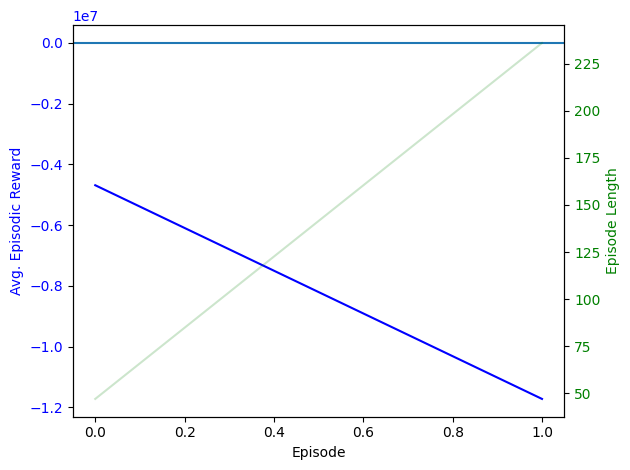

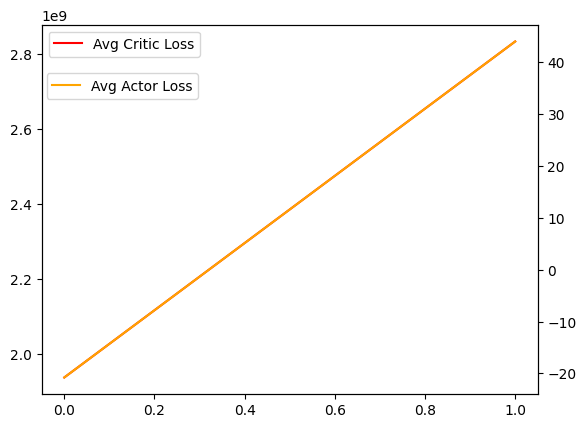

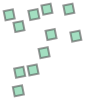

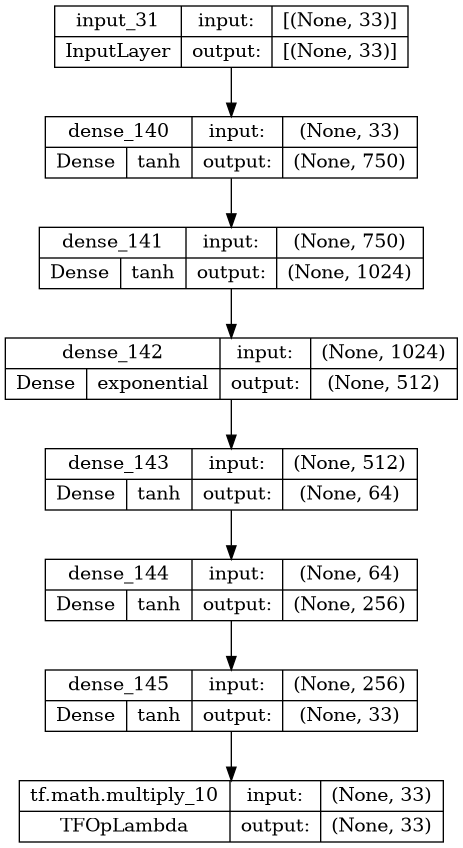

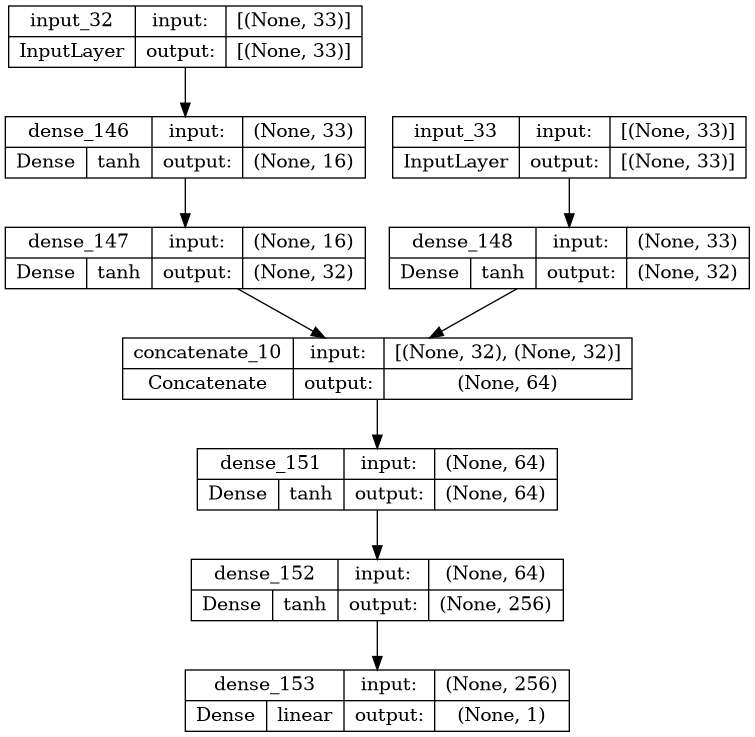

In [62]:
save_output(run, 'run4')
# Alarm to let me know the run is finished
# subprocess.run(['haruna', '/home/zeke/Music/alarm-tone.wav'])
display(clear=True)
run()


In [63]:
# Save the weights
# actor_model.save_weights(actor_weights_file)
# critic_model.save_weights(critic_weights_file)

# target_actor.save_weights(target_actor_weights_file)
# target_critic.save_weights(target_critic_weights_file)
